In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(r"bank-full.csv", sep=";")
data.sample()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3918,42,blue-collar,married,secondary,no,314,yes,yes,unknown,16,may,269,2,-1,0,unknown,no


In [3]:
df = data[['age', 'job', 'marital', 'education', 'balance', 'housing',
        'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']]

In [4]:
from sklearn.model_selection import train_test_split

df['y'] = df['y'].map({'no':0, 'yes':1})

categorical = data.dtypes[data.dtypes=='object'].index

df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

<ipython-input-4-3461ce7d3353>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['y'].map({'no':0, 'yes':1})


In [5]:
question = """
Question 1:
ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the y variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable.
You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

balance
day
duration
previous
"""

In [6]:
from sklearn.metrics import roc_auc_score
import numpy as np

categorical = data.dtypes[data.dtypes=='object'].index
numerical = data.dtypes[data.dtypes!='object'].index
x_train = df_train.drop('y', axis=1)
y_train = df_train.y

auc_scores = {}

# Calculate AUC for each variable
for col in numerical:
    feature = x_train[col]
    auc = roc_auc_score(y_train, feature)

    # If AUC is less than 0.5, invert the variable by multiplying by -1
    if auc < 0.5:
        feature = -x_train[col]
        auc = roc_auc_score(y_train, feature)

    auc_scores[col] = auc

auc_scores

{'age': 0.5078795078209138,
 'balance': 0.5958938470734785,
 'day': 0.525885395497173,
 'duration': 0.8098344723810027,
 'campaign': 0.5710211146019857,
 'pdays': 0.5937847617350412,
 'previous': 0.6031461321943353}

In [7]:
question = """
Question 2:

Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.69, 0.79, 0.89, 0.99
"""

In [8]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

X = df.drop('y', axis=1)
y = df.y
X = X.to_dict(orient='records')

x_train_full, x_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.25, random_state=11)

x_train= dv.fit_transform(x_train)
x_val  = dv.transform(x_val)
x_test = dv.transform(x_test)

model.fit(x_train,y_train)
y_pred_proba = model.predict_proba(x_val)[:,1]
auc = roc_auc_score(y_val, y_pred_proba)
auc_rounded = round(auc, 3)

print("AUC on the validation dataset:", auc_rounded)

AUC on the validation dataset: 0.904


In [9]:
question = """
Question 3:

Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.265, 0.465, 0.665, 0.865
"""

In [10]:
scores = []
thresholds = np.linspace(0, 1, 101)

y_pred = model.predict_proba(x_val)[:,1]
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

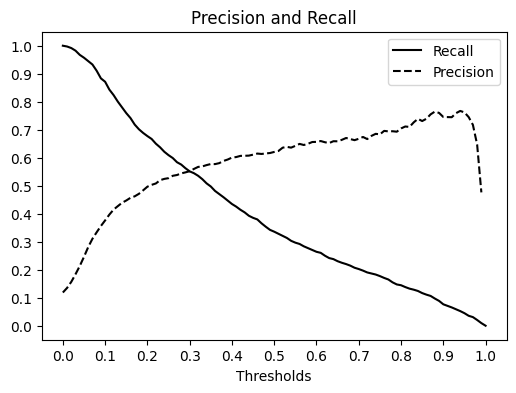

In [11]:
plt.figure(figsize=(6, 4))

plt.plot( df_scores.threshold, df_scores.recall, color='black', linestyle='solid', label='Recall')
plt.plot( df_scores.threshold,df_scores.precision, color='black', linestyle='dashed', label='Precision')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('Precision and Recall')

plt.show()

In [12]:
question="""
Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down.
That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
F1 = 2⋅(P⋅R)(P+R)

Where : P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
At which threshold F1 is maximal?

0.02, 0.22, 0.42, 0.62
"""

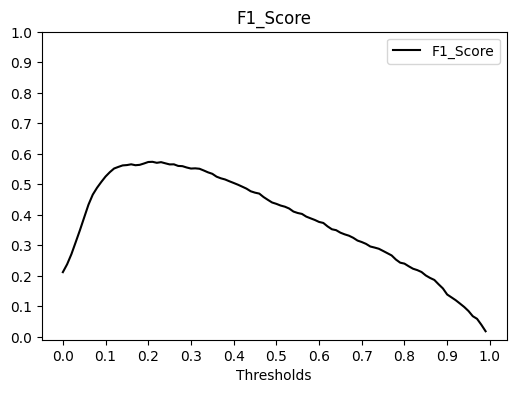

In [13]:
df_scores['fscore'] = 2 * ((df_scores.recall * df_scores.precision)/(df_scores.recall + df_scores.precision))

plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.fscore, color='black', linestyle='solid', label='F1_Score')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('F1_Score')

plt.show()

In [14]:
df_scores[df_scores['fscore']== df_scores['fscore'].max()]

,threshold,tp,fp,fn,tn,precision,recall,fscore
21,0.21,715,706,357,7264,0.503167,0.666978,0.573606


In [15]:
question="""
Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001, 0.006, 0.06, 0.26"""

In [16]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)
X = df.drop('y', axis=1)
y = df['y']

def train(X, y):
    X = X.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_trans = dv.fit_transform(X)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_trans, y)

    return dv, model

def predict(X, dv, model):
    X = X.to_dict(orient='records')
    X_trans = dv.transform(X)

    y_pred = model.predict_proba(X_trans)[:, 1]

    return y_pred

aucs = []

for train_idx, val_idx in kf.split(df):
    df_train = df.iloc[train_idx]
    df_val = df.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train.drop('y', axis=1), y_train)

    y_pred = predict(df_val.drop('y', axis=1), dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

print('AUC %.3f +- %.3f' % (np.mean(aucs), np.std(aucs)))


AUC 0.906 +- 0.004


In [17]:
question = """
Question 6:

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?
0.000001, 0.001, 1 """

In [18]:
def train(df, y, C=1.0):
    X = df.drop('y', axis=1)
    X = X.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(X)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model


nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=1e-06, auc = 0.702 ± 0.009
C=0.001, auc = 0.865 ± 0.007
C=1, auc = 0.907 ± 0.005
